# Robustness Analysis

Ideas:
- sort nodes by different metrics and remove them in order.
- groups nodes in different categories, sort the categories, and remove the nodes accordingly.

Todo:
- define all the metrics to track.

Due-diligence:
- calculate the compute time before pressing run.

Possible Products:
- static charts.
- create gif for every metric.
- create real-time refreshing dashboard.

# Pipeline

- Check that set of nodes of graph has same nodes as list of nodes with habitats
- Extract unique values of habitats
- Build habitat buckets (1 key for each unique value, no problem if count 2 in one bucket and 2 in another) (build one also for food groups)
- Compute probability distribution of habitat buckets
- Build node buckets with same key as habitat buckets
- Retrieve random key according to probability distribution assigned to habitat buckets

### LOG
- All nodes with rank food_group (not species) should not be removed in the perturbations, because they are to broad categories to ever die out.

- Maybe calculate metrics modulo %.

In [10]:
import networkx as nx
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [11]:
def load_graph():
    csv_file = "../food_webs/02_metaweb_unrestrained.csv"
    edge_data_df = pd.read_csv(csv_file, low_memory=False)
    G = nx.from_pandas_edgelist(edge_data_df, source='Source_Name', target='Target_Name', edge_attr=True, create_using=nx.DiGraph())

    return nx.reverse(G)

G = load_graph()

In [12]:
def node_removal(graph, node):

    k_level_neighbors = set(graph.successors(node))
    graph.remove_node(node)

    # Explore neighbors level after level
    while len(k_level_neighbors) > 0:

        new_level_neighbors = set()
        removed_neighbors = set()

        # In the worst case the check must be done |k_level_neighbors| times
        for i in range(len(k_level_neighbors)):
            change_flag = False  # flag indicating if any nodes were removed in this loop

            for neighbor in set(k_level_neighbors):  # TODO: check scenario of copying set and without
                
                # A node is removed if it does not have any inward edge, if it's isolated, or if it's an isolated self-loop
                if graph.in_degree(neighbor) == 0 or graph.degree(neighbor) == 0 or (graph.in_degree(neighbor) == 1 and graph.has_edge(neighbor, neighbor)):
                    new_level_neighbors.update(set(graph.successors(neighbor)))
                    k_level_neighbors.remove(neighbor)
                    removed_neighbors.add(neighbor)
                    graph.remove_node(neighbor)

                    change_flag = True
            
            if not change_flag:
                break

        k_level_neighbors = new_level_neighbors - removed_neighbors

In [13]:
def habitat_bucket_probabilites(habitat_buckets, lost_habitat=['Grassland', '']):
    """ 
    Food groups have a zero probability of being removed.
    """
    proportions = []

    foud_groups = habitat_buckets.popitem() 

    for hb in list(habitat_buckets.keys()):
        proportions.append(len([s for s in hb if  s == lost_habitat]) / len(hb))  # TODO: grep string of habitats!!!!!!!!

    n = len(proportions)
    total = sum(proportions)
    min_category_proportion = 0.05  # background extinction 
    smoothing = min_category_proportion * total / (1 - min_category_proportion * n)

    smoothed_proportions = [p + smoothing for p in proportions]
    total = sum(smoothed_proportions)
    normalized_smoothed_proportions = [p / total for p in smoothed_proportions]

    normalized_smoothed_proportions.append(0) 
    habitat_buckets['food_groups'] = foud_groups

    return normalized_smoothed_proportions

In [3]:
import pandas as pd
csv_file = "../food_webs/02_metaweb_unrestrained.csv"
edge_data_df = pd.read_csv(csv_file, low_memory=False)

unique_habs = pd.unique(edge_data_df['Habitat'])

In [14]:
def habitat_buckets(nodes_df):
    habitats = pd.unique(nodes_df['habitat'])

    buckets = {}  # Changed variable name here

    for habitat in habitats:
        buckets[habitat] = []

    # mock result
    buckets = {
        ('g'): (), 
        ('g', 'other'): (),
        ('g', 'other', 'other'): (),
        ('other'): (),
        ('food_groups'): ()  # pay special attention to this one 
    }

    return buckets  # And here

def bucket_probabilities(habitat_buckets):
    normalized_smoothed_proportions = habitat_bucket_probabilites(habitat_buckets, 'g')
    return normalized_smoothed_proportions

def habitat_buckets_and_probabilities(nodes_df):
    buckets = habitat_buckets(nodes_df)  # Changed function call here
    habitat_probabilities = bucket_probabilities(buckets)  # And here

    # add nodes to habitat buckets
    for _, row in nodes_df.iterrows():
        node = row['specie']
        habitat = row['habitat']
        buckets[habitat].append(node)  # And here

    return buckets, habitat_probabilities  # And finally here

In [15]:
def choose_node(buckets, habitat_probabilities):
    # Choose a bucket
    bucket_keys = list(buckets.keys())
    chosen_bucket = np.random.choice(bucket_keys, p=habitat_probabilities)

    # Choose a node from the bucket
    nodes_in_bucket = buckets[chosen_bucket]
    chosen_node = np.random.choice(nodes_in_bucket)

    return chosen_node

In [ ]:
csv = 'node_lists/all_species_and_feeding_groups'
nodes_df = pd.DataFrame(data=csv, columns=['specie', 'habitat'])
n = len(nodes_df)

buckets, habitat_probabilities = habitat_buckets_and_probabilities(csv)

""" 

for i in range(n):
    node = choose_node(buckets, habitat_probabilities)
    node_removal(node)

    # compute metrics

"""

# Perturbations

TODO: variance of results across permutations.

In [ ]:
%%time

# Get list of all nodes in the graph
all_nodes = list(G.nodes())

# Get a list of 200 random nodes
threatened_species = random.sample(all_nodes, 200)

# Metrics List
metrics = ['density', 'avg_degree'] # TODO: add metrics

# Initialize dictionaries for averaging values j for each metric k, for final gif
metrics_simulation_averages = {}
for metric in metrics:
    metrics_simulation_averages[metric] = {'averages': []}

# When all have threatened species have been removed
for metric in metrics:
    for i in range(len(threatened_species)):
        metrics_simulation_averages[metric]['averages'].append(0)

# Number of permutations
num_permutations = 1000

for permutation in range(num_permutations):
    # Initialize dictionaries for storing the values of the metrics before removal in simulation i
    metrics_dict = {}
    for metric in metrics:
        metrics_dict[metric] = {'values': []}

    # Copy of the original graphs for this permutation
    graph = G.copy()
    undirected_graph = undirected_G.copy()

    # Randomly shuffle the list of threatened species
    random.shuffle(threatened_species)

    for species in threatened_species:
        # Remove the species from the graph
        graph.remove_node(species)
        undirected_graph.remove_node(species)

        # Compute metrics after removal # TODO: initialize state of graph before and append after code
        density = nx.density(undirected_graph)
        avg_degree = np.mean([degree for d, degree in nx.degree(undirected_graph)])
        #avg_pagerank = np.mean([pagerank for pr, pagerank in nx.pagerank(graph)])
        #num_SSC = len(nx.strongly_connected_components(graph))

        metrics_dict['avg_degree']['values'].append(avg_degree)
        metrics_dict['density']['values'].append(density)

    # When all have threatened species have been removed
    for metric in metrics:
        for i in range(len(threatened_species)):
            metrics_simulation_averages[metric]['averages'][i] = (metrics_simulation_averages[metric]['averages'][i]*permutation + metrics_dict[metric]['values'][i]) / (permutation+1)

CPU times: user 35.2 s, sys: 409 ms, total: 35.6 s
Wall time: 35.6 s


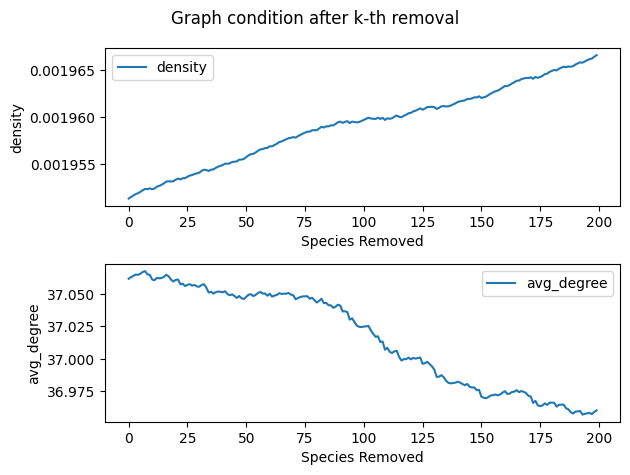

In [ ]:
# Create a subplot for each metric
fig, axs = plt.subplots(len(metrics), 1)
fig.suptitle('Graph condition after k-th removal')

# Loop through each metric
for idx, metric in enumerate(metrics):
    averages = metrics_simulation_averages[metric]['averages']

    # Plot the metric on its own subplot
    axs[idx].plot(averages, label=metric)
    axs[idx].set_xlabel('Species Removed')
    axs[idx].set_ylabel(f'{metric}')
    axs[idx].legend(loc='best')  # Show legend in the best location

# Improve layout
plt.tight_layout()
plt.show()